# Failure Rate Calculation

Reproduce book calculations related to failure rates

In [1]:
# Check if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Set up helper functions
if IN_COLAB:
    # Download helper functions
    !wget -q https://raw.githubusercontent.com/yourusername/my-earthquake-book/main/helpers/utils.py
    !wget -q https://raw.githubusercontent.com/yourusername/my-earthquake-book/main/helpers/data_utils.py
    
    # Download any required data files
    !wget -q https://raw.githubusercontent.com/yourusername/my-earthquake-book/main/data/sample_data.csv

# Import helper functions
# from utils import calculate_fragility, plot_fragility_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm # type: ignore

# Set up color and line style specifications
colors = {
    1: np.array([56, 95, 150])/255,
    2: np.array([207, 89, 33])/255,
    3: np.array([158, 184, 219])/255,
    4: np.array([231, 184, 0])/255,
    5: np.array([128, 0, 0])/255
}

Specify a hazard curve and fragility parameters

In [3]:
# load hazard curve (from simplified logic tree example)
hazard_curve = pd.read_csv('../data/hazard_curve_1.csv', dtype={'im': float, 'lambda_im': float})


# Define fragility function parameters
thetaIM = 0.5  # Fragility median
betaIM = 0.4   # Fragility beta (standard deviation of the natural log of the IM)


Calculate and plot the fragility function

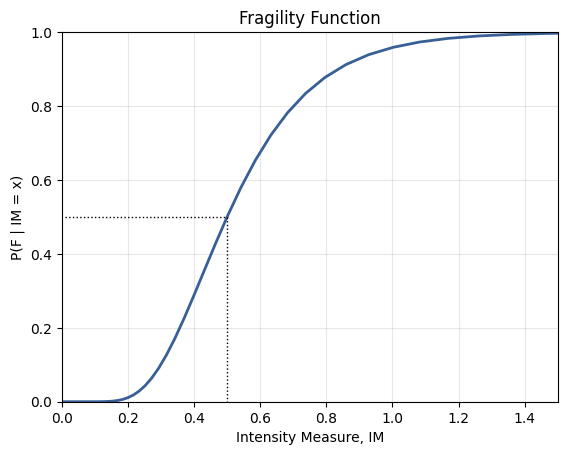

In [ ]:
# Calculate the fragility function (probability of failure given IM)
pFail = norm.cdf(np.log(im), np.log(thetaIM), betaIM)

# Plot the fragility function
plt.figure
plt.plot(x, pFail, '-', color=colors[1], linewidth=2)
plt.plot([0.01, thetaIM, thetaIM], [0.5, 0.5, 0], 'k:', linewidth=1)
plt.xlabel('Intensity Measure, IM')
plt.ylabel('P(F | IM = im)')
plt.axis([0, 1.5, 0, 1])
plt.grid(alpha=0.3)
plt.show()

Failure rate calculations

In [ ]:
# Calculate failure rate
# Take the absolute value of the negative derivative of the hazard curve
dLambda = np.abs(np.append(np.diff(lambda_im), 0))
failContrib = pFail * dLambda
failRate = np.sum(failContrib)
print(f"Failure Rate: {failRate:.6e}")

# Plot hazard and fragility on the same plot using two y-axes
fig, ax1 = plt.subplots()

# Left y-axis: fragility function
ax1.set_xlabel('SA(1 s) [g]')
ax1.set_ylabel('Failure probability, P(F | IM = x)')
ax1.plot(x, pFail, '-', color=colors[1], linewidth=2, label='Fragility, θ = 0.5 g')
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='black')

# Right y-axis: hazard curve
ax2 = ax1.twinx()
ax2.set_ylabel('Annual rate of exceedance, λ(IM>x)')
ax2.plot(x, lambda_im, '-', color=colors[3], linewidth=2, label='Ground-motion hazard')
ax2.set_ylim(0, 0.002)
ax2.tick_params(axis='y', labelcolor='black')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'lambdaIM' is not defined

Failure Rate (discrete): 5.820396e-05


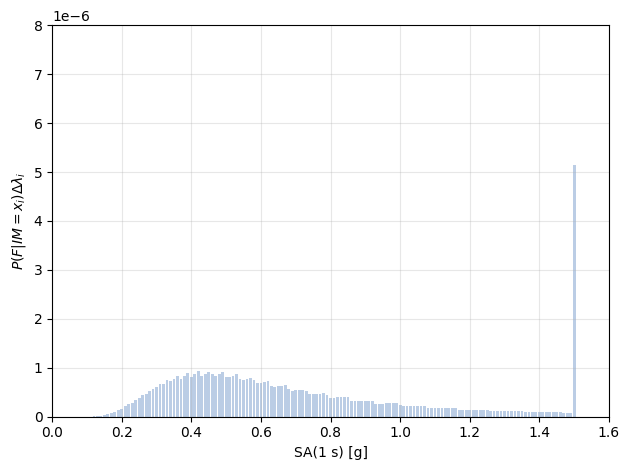

In [ ]:
# Discretize for tabular output
xShort = np.arange(0.01, 1.51, 0.01)
lambdaShort = np.interp(xShort, x, lambda_im)
dLambdaShort = np.abs(np.append(np.diff(lambdaShort), lambdaShort[-1]))
pFailShort = norm.cdf(np.log(xShort), np.log(thetaIM), betaIM)

failRateDiscrete = np.sum(pFailShort * dLambdaShort)
print(f"Failure Rate (discrete): {failRateDiscrete:.6e}")

# Plot the failure rate contributions as a bar chart
plt.figure()
plt.bar(xShort, pFailShort * dLambdaShort, width=0.008, color=colors[3], alpha=0.7)
plt.xlabel('SA(1 s) [g]')
plt.ylabel('$P(F | IM = x_i) Δλ_i$')
plt.xlim(0, 1.6)
plt.ylim(0, 8e-6)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Selected IM level contributions to failure rate:


,IM,P(F|IM),ΔλIM,Contribution
0,0.01,6.856630e-23,2.605506e-03,1.786499e-25
1,0.11,7.675566e-05,5.449511e-05,4.182808e-09
2,0.21,1.505078e-02,1.389401e-05,2.091157e-07
3,0.31,1.160260e-01,5.697270e-06,6.610316e-07
4,0.41,3.099023e-01,2.809923e-06,8.708015e-07
5,0.51,5.197422e-01,1.548423e-06,8.047806e-07
6,0.61,6.904503e-01,1.028849e-06,7.103689e-07
7,0.71,8.096595e-01,6.772416e-07,5.483351e-07
8,0.81,8.861039e-01,4.415860e-07,3.912911e-07
9,0.91,9.328152e-01,3.552976e-07,3.314270e-07


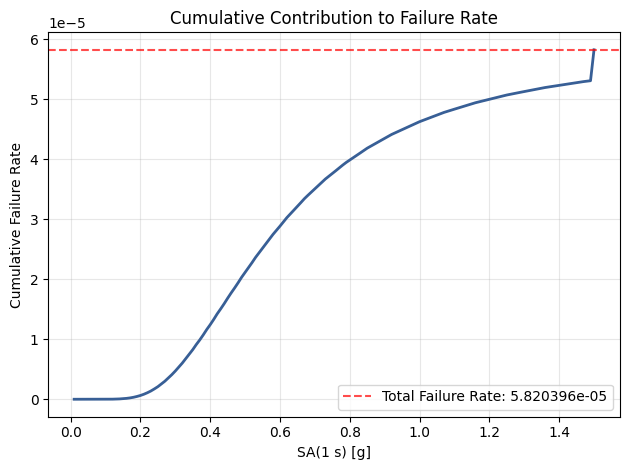

In [ ]:

# Optional: Display the contributions for selected IM levels in a table
import pandas as pd

# Create a DataFrame for selected IM levels for demonstration
selected_indices = np.arange(0, len(xShort), 10)  # Every 10th value
selected_IM = xShort[selected_indices]
selected_pFail = pFailShort[selected_indices]
selected_dLambda = dLambdaShort[selected_indices]
selected_contrib = selected_pFail * selected_dLambda

df = pd.DataFrame({
    'IM': selected_IM,
    'P(F|IM)': selected_pFail,
    'ΔλIM': selected_dLambda,
    'Contribution': selected_contrib
})

print("Selected IM level contributions to failure rate:")
display(df)
